In [1]:
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.

# Creating a Scalable Recommender with Apache Spark & Elasticsearch

In this notebook, you will create a recommendation engine using Spark and Elasticsearch. Using some movie rating data,
you will train a collaborative filtering model in Spark and export the trained model to Elasticsearch. Once exported, 
you can test your recommendations by querying Elasticsearch and displaying the results.

### _Prerequisites_

The notebook assumes you have installed Elasticsearch, Apache Spark and the Elasticsearch Spark connector detailed in the [setup steps](https://github.com/MLnick/elasticsearch-spark-recommender-demo/tree/master#steps).

> _Optional:_

> In order to display the images in the recommendation demo, you will need to access [The Movie Database API](https://www.themoviedb.org/documentation/api). Please follow the [instructions](https://developers.themoviedb.org/3/getting-started) to get an API key.

## Overview

You will work through the following steps

1. Prepare the data by loading it into Elasticsearch
2. Load the movie data into Spark DataFrames and use the Elasticsearch Spark connector to save it
to the newly created Elasticsearch index
3. Load ratings data and run ALS
3. Save ALS model factors to Elasticsearch
4. Show similar items using Elasticsearch vector scoring plugin



#### Requirements

Requires [Spark `2.1.0`](http://spark.apache.org/downloads.html), [Elasticsearch `5.3.0`](https://www.elastic.co/downloads/past-releases/elasticsearch-5-3-0), [`elasticsearch-hadoop 5.3.0`](https://www.elastic.co/downloads/past-releases/elasticsearch-apache-hadoop-5-3-0) and [`elasticsearch-vector-scoring 5.3.0`](https://github.com/MLnick/elasticsearch-vector-scoring).

*Elasticsearch vector scoring plugin* must be [installed first](https://github.com/MLnick/elasticsearch-vector-scoring#plugin-installation).

For reference, the code to create Elasticsearch mappings is shown here (see `Enrich & Prepare MovieLens Dataset.ipynb` for full details). This notebook assumes these mappings have been pre-created - so we start from Step 2.

## Step 1: Prepare the data

* This notebook uses the "small" version of the latest MovieLens movie rating dataset, containing about 100,000 ratings, 9,000 movies and 700 users
* The latest version of the data can be downloaded at https://grouplens.org/datasets/movielens/latest/
* Download the `ml-latest-small.zip` file and unzip it to a suitable location on your system.

The folder should contain a number of CSV files. We will be using the following files:
* `ratings.csv` - movie rating data
* `links.csv` - external database ids for each movie
* `movies.csv` - movie title and genres

In [2]:
# first import a few utility methods that we'll use later on
from IPython.display import Image, HTML, display
# check PySpark is running
spark

### Load rating and movie data

In [3]:
# change the path below to point to the correct base folder
PATH_TO_DATA = "/Users/nick/workspace/datasets/ml-latest-small"
# PATH_TO_DATA = "FOLDER/ml-latest-small"

**Ratings**

The ratings data consists of around 100,000 ratings given by users to movies. Each row of the `DataFrame` consists of a `userId`, `movieId` and `timestamp` for the event, together with the `rating` given by the user to the movie

In [4]:
# load ratings data
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("Number of ratings: %i" % ratings.count())
print("Sample of ratings:")
ratings.show(5)

Number of ratings: 100004
Sample of ratings:
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



[convert timestamp ]

In [5]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(5)

+------+-------+------+-------------+
|userId|movieId|rating|    timestamp|
+------+-------+------+-------------+
|     1|     31|   2.5|1260759144000|
|     1|   1029|   3.0|1260759179000|
|     1|   1061|   3.0|1260759182000|
|     1|   1129|   2.0|1260759185000|
|     1|   1172|   4.0|1260759205000|
+------+-------+------+-------------+
only showing top 5 rows



**Users**

The dataset only contains anonymous user ids. For the purposes of this demo we will create some random user names using the Python package `names`.

In [7]:
import names
from pyspark.sql.functions import udf
from pyspark.sql.types import *
# define UDF to create random user names
random_name = udf(lambda x: names.get_full_name(), StringType())

# create a user data set from the unique user ids in the ratings dataset
unique_users = ratings.select("userId").distinct()
users = unique_users.select("userId", random_name("userId").alias("name"))
users.cache()
print("Number of users: %i" % (users.count()))
print("Sample of users:")
users.show(5)

Number of users: 671
Sample of users:
+------+----------------+
|userId|            name|
+------+----------------+
|    12|    Maria Moreno|
|    13| Matthew Mendoza|
|    14|  Deloris Crouch|
|    18| Janet Gillespie|
|    38|Phyllis Bankston|
+------+----------------+
only showing top 5 rows



**Movies**

The file `movies.csv` contains the `movieId`, `title` and `genres` for each movie. As you can see, the `genres` field is a bit tricky to use, as the genres are in the form `Adventure|Animation|Children|Comedy|Fantasy`.

In [8]:
# load raw data from CSV
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



Let's create a SparkSQL function to extract this delimited string into a list of genres.

In [9]:
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



Ok, that looks better!

You may also notice that the movie titles contain the year of release. It would be useful to have that as a field in our search index for filtering results. Let's create a UDF to extract the release year from the title using a Python regular expression.

In [10]:
import re
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

Ok the function works! Let's create a new `DataFrame` with the cleaned-up titles, release dates and genres of our movies.

In [11]:
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



Next, we will join the `links.csv` data to `movies` so that we have the `TMDb id` corresponding to each movie. We can use this to look up movie poster images.  

In [12]:
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)
# join movies with links to get TMDB id
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

> **_Optional_**

> Run the below code to test your access to TMDb API. You should see the _Toy Story_ movie poster displayed inline.

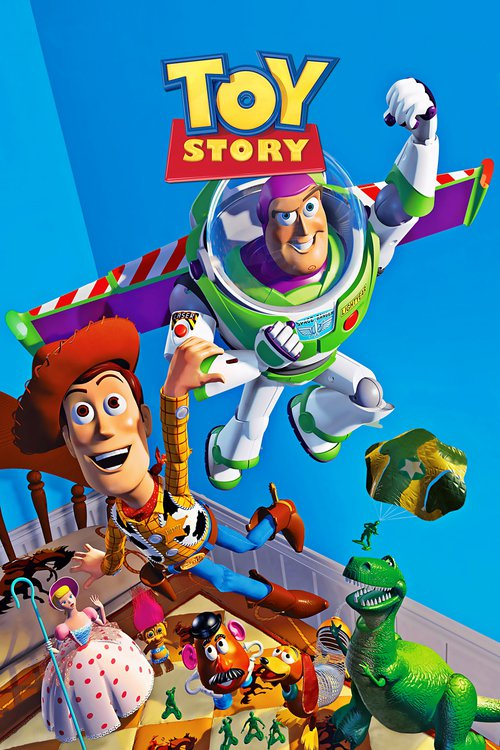

In [13]:
import tmdbsimple as tmdb
#tmdb.API_KEY = 'YOUR_API_KEY'
tmdb.API_KEY = '6a1cf3f01fd70e17b5393ef1ba162909'
# base URL for TMDB poster images
IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
# from requests import HTTPError

movie_id = movie_data.first().tmdbId
movie_info = tmdb.Movies(movie_id).info()
movie_poster_url = IMAGE_URL + movie_info['poster_path']
display(Image(movie_poster_url, width=200))

## Step 2: Load data into Elasticsearch

[ ]

In [14]:
from elasticsearch import Elasticsearch

# test your ES instance is running
es = Elasticsearch()
es.info(pretty=True)

{'cluster_name': 'elasticsearch',
 'cluster_uuid': 'VHyfVD3IQ_Wp751Hca7dfw',
 'name': '2Zs8kW3',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2017-03-23T03:31:50.652Z',
  'build_hash': '3adb13b',
  'build_snapshot': False,
  'lucene_version': '6.4.1',
  'number': '5.3.0'}}

**Create an Elasticsearch index with mappings for users, movies and rating events**

References:
* [Create index request](https://www.elastic.co/guide/en/elasticsearch/reference/current/indices-create-index.html)
* [Delimited payload filter](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-delimited-payload-tokenfilter.html)
* [Term vectors](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/docs-termvectors.html#_term_information)
* [Mapping](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/mapping.html)

In [15]:
create_index = {
    "settings": {
        "analysis": {
            "analyzer": {
                "payload_analyzer": {
                    "type": "custom",
                    "tokenizer":"whitespace",
                    "filter":"delimited_payload_filter"
                }
            }
        }
    },
    "mappings": {
        "ratings": {
          "properties": {
                "timestamp": {
                    "type": "date"
                },
                "userId": {
                    "type": "integer"
                },
                "movieId": {
                    "type": "integer"
                },
                "rating": {
                    "type": "double"
                }
            }  
        },
        "users": {
            "properties": {
                "userId": {
                    "type": "integer"
                },
                "name": {
                    "type": "text"
                },
                "@model": {
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        },
        "movies": {
            "properties": {
                "movieId": {
                    "type": "integer"
                },
                "tmdbId": {
                    "type": "keyword"
                },
                "genres": {
                    "type": "keyword"
                },
                "release_date": {
                    "type": "date",
                    "format": "year"
                },
                "@model": {
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        }
    }
}
# create index with the settings & mappings above
es.indices.create(index="demo", body=create_index)

{'acknowledged': True, 'shards_acknowledged': True}

**Load User, Movie and Ratings DataFrames into Elasticsearch**

In [16]:
# write ratings data
ratings.write.format("es").save("demo/ratings")
# check write went ok
print("Dataframe count: %d" % ratings.count())
print("ES index count:  %d" % es.count(index="demo", doc_type="ratings")['count'])

Dataframe count: 100004
ES index count:  100004


In [17]:
es.search(index="demo", doc_type="ratings", q="*", size=3)

{'_shards': {'failed': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': 'AV5cAJu7fzgzN9-xoTQZ',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'movieId': 1293,
     'rating': 2.0,
     'timestamp': 1260759148000,
     'userId': 1},
    '_type': 'ratings'},
   {'_id': 'AV5cAJu7fzgzN9-xoTQb',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'movieId': 1343,
     'rating': 2.0,
     'timestamp': 1260759131000,
     'userId': 1},
    '_type': 'ratings'},
   {'_id': 'AV5cAJu7fzgzN9-xoTQi',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'movieId': 2294,
     'rating': 2.0,
     'timestamp': 1260759108000,
     'userId': 1},
    '_type': 'ratings'}],
  'max_score': 1.0,
  'total': 100004},
 'timed_out': False,
 'took': 1}

In [18]:
# write user data, specifying the DataFrame column to use as the id mapping
users.write.format("es").option("es.mapping.id", "userId").save("demo/users")
# check write went ok
print("User DF count: %d" % users.count())
print("ES index count: %d" % es.count(index="demo", doc_type="users")['count'])

User DF count: 671
ES index count: 671


In [19]:
es.search(index="demo", doc_type="users", q="*", size=3)

{'_shards': {'failed': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': '25',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'name': 'Maria Moreno', 'userId': 25},
    '_type': 'users'},
   {'_id': '52',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'name': 'Janet Gillespie', 'userId': 52},
    '_type': 'users'},
   {'_id': '73',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'name': 'Jerry Briseno', 'userId': 73},
    '_type': 'users'}],
  'max_score': 1.0,
  'total': 671},
 'timed_out': False,
 'took': 1}

In [20]:
# write movie data, specifying the DataFrame column to use as the id mapping
movie_data.write.format("es").option("es.mapping.id", "movieId").save("demo/movies")
# check load went ok
print("Movie DF count: %d" % movie_data.count())
print("ES index count: %d" % es.count(index="demo", doc_type="movies")['count'])

Movie DF count: 9125
ES index count: 9125


In [21]:
es.search(index="demo", doc_type="movies", q="*", size=3)

{'_shards': {'failed': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': '14',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'genres': ['drama'],
     'movieId': 14,
     'release_date': '1995',
     'title': 'Nixon',
     'tmdbId': 10858},
    '_type': 'movies'},
   {'_id': '19',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'genres': ['comedy'],
     'movieId': 19,
     'release_date': '1995',
     'title': 'Ace Ventura: When Nature Calls',
     'tmdbId': 9273},
    '_type': 'movies'},
   {'_id': '22',
    '_index': 'demo',
    '_score': 1.0,
    '_source': {'genres': ['crime', 'drama', 'horror', 'mystery', 'thriller'],
     'movieId': 22,
     'release_date': '1995',
     'title': 'Copycat',
     'tmdbId': 1710},
    '_type': 'movies'}],
  'max_score': 1.0,
  'total': 9125},
 'timed_out': False,
 'took': 1}

## Step 3: Train a recommmender model on the ratings data

[TBC]

In [22]:
ratings_from_es = spark.read.format("es").load("demo/ratings")
ratings_from_es.printSchema()
ratings_from_es.show(5)

root
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- userId: integer (nullable = true)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|   1287|   2.0|2009-12-14 04:53:07|     1|
|   1405|   1.0|2009-12-14 04:53:23|     1|
|   1953|   4.0|2009-12-14 04:53:11|     1|
|     10|   4.0|1996-06-21 13:11:33|     2|
|    144|   3.0|1996-06-21 13:20:16|     2|
+-------+------+-------------------+------+
only showing top 5 rows



In [23]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.1, rank=10, seed=42)
model = als.fit(ratings_from_es)
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.65529627, -0....|
| 20|[-0.08578758, -0....|
| 30|[0.14903268, 0.11...|
| 40|[-0.07772923, 0.2...|
| 50|[-0.22381878, -0....|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.37270272, 0.0...|
| 20|[-0.52351207, -0....|
| 30|[-0.9530989, -0.0...|
| 40|[-0.14209941, 0.1...|
| 50|[-0.5712305, 0.34...|
+---+--------------------+
only showing top 5 rows



## Step 4: Export ALS user and item factor vectors to Elasticsearch

[TBC]

### Utility functions for converting factor vectors

In [24]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, lit, current_timestamp, unix_timestamp

def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

def vector_to_struct(x, version, ts):
    '''Convert a vector to a SparkSQL Struct with string-format vector and version fields'''
    return (convert_vector(x), version, ts)

vector_struct = udf(vector_to_struct, \
                    StructType([StructField("factor", StringType(), True), \
                                StructField("version", StringType(), True),\
                                StructField("timestamp", LongType(), True)]))

In [25]:
# test out the vector conversion function
test_vec = model.userFactors.select("features").first().features
print(test_vec)
print()
print(convert_vector(test_vec))

[-0.655296266078949, -0.07208383828401566, 1.184463381767273, -0.8777399063110352, 0.34049999713897705, -0.4350639879703522, 0.15437132120132446, 0.5911734104156494, 0.27180013060569763, 0.9368487000465393]

0|-0.655296266078949 1|-0.07208383828401566 2|1.184463381767273 3|-0.8777399063110352 4|0.34049999713897705 5|-0.4350639879703522 6|0.15437132120132446 7|0.5911734104156494 8|0.27180013060569763 9|0.9368487000465393


### Convert factor vectors to [factor, version] form and write to Elasticsearch

In [26]:
ver = model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = model.itemFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
movie_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)
user_vectors = model.userFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
user_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|-0.372702717781...|ALS_46d1b78f8b7e0...|1504782131|
| 20|0|-0.523512065410...|ALS_46d1b78f8b7e0...|1504782131|
| 30|0|-0.953098893165...|ALS_46d1b78f8b7e0...|1504782131|
| 40|0|-0.142099410295...|ALS_46d1b78f8b7e0...|1504782131|
| 50|0|-0.571230471134...|ALS_46d1b78f8b7e0...|1504782131|
+---+--------------------+--------------------+----------+
only showing top 5 rows

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|-0.655296266078...|ALS_46d1b78f8b7e0...|1504782131|
| 20|0|-0.085787579417...|ALS_46d1b78f8b7e0...|1504782131|
| 30|0|0.1490326821804...|ALS_46d1b78f8b7e0...|1504782131|
| 40|0|-0.077729232609...|ALS_46d1b78f8b7e0...|1504782131|
| 50|0|-0.223818778991...|ALS_4

In [27]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("demo/movies", mode="append")

In [28]:
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("demo/users", mode="append")

### Check the data  was written correctly

In [50]:
# search for a particular sci-fi movie
es.search(index="demo", doc_type="movies", q="star wars phantom menace", size=1)['hits']['hits'][0]

{'_id': '2628',
 '_index': 'demo',
 '_score': 10.289563,
 '_source': {'@model': {'factor': '0|-0.40737640857696533 1|-0.20495127141475677 2|0.5859120488166809 3|-1.4034539461135864 4|0.7977182269096375 5|-0.005322572309523821 6|-0.529588520526886 7|0.08730430901050568 8|0.07123260945081711 9|0.7355672717094421',
   'timestamp': 1504782133,
   'version': 'ALS_46d1b78f8b7e0f307d30'},
  'genres': ['action', 'adventure', 'sci-fi'],
  'id': 2628,
  'movieId': 2628,
  'release_date': '1999',
  'title': 'Star Wars: Episode I - The Phantom Menace',
  'tmdbId': 1893},
 '_type': 'movies'}

## Step 5: Recommend using Elasticsearch!

In [30]:
import tmdbsimple as tmdb
from requests import HTTPError
from IPython.display import Image, HTML, display

tmdb.API_KEY = '6a1cf3f01fd70e17b5393ef1ba162909'
# base URL for TMDB poster images
IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    
def get_poster_url(id):
    movie = tmdb.Movies(id).info()
    poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
    return poster_url
    
def fn_query(query_vec, q="*", cosine=False):
    return {
    "query": {
        "function_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script_score": {
                "script": {
                        "inline": "payload_vector_score",
                        "lang": "native",
                        "params": {
                            "field": "@model.factor",
                            "vector": query_vec,
                            "cosine" : cosine
                        }
                    }
            },
            "boost_mode": "replace"
        }
    }
}

def get_similar(the_id, q="*", num=10, index="demo", dt="movies"):
    response = es.get(index=index, doc_type=dt, id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=True)
        results = es.search(index, dt, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]

def display_similar(the_id, q="*", num=10, index="demo", dt="movies"):
    movie, recs = get_similar(the_id, q, num, index, dt)
    # display query
    q_im_url = get_poster_url(movie['tmdbId'])
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>Similar movies:</h2>"))
    sim_html = "<table border=0><tr>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        sim_html += "<td><img src=%s width=200></img></td><td>%2.3f</td>" % (r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

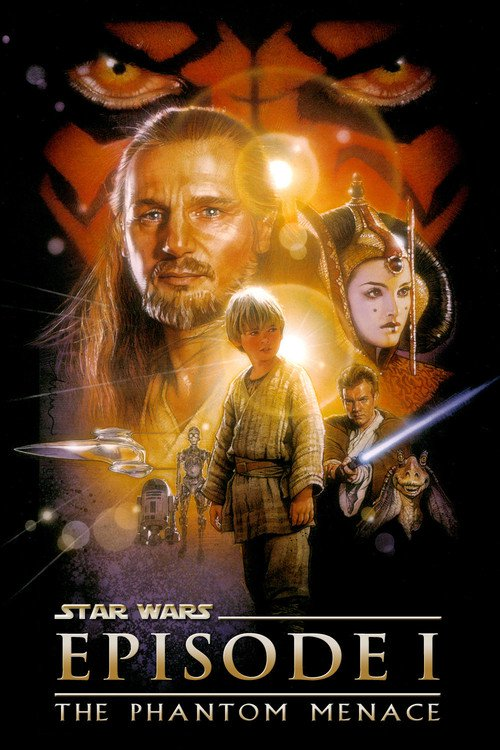

,0.983,,0.973,,0.965,,0.964,,0.961


In [40]:
display_similar(2628, num=5)

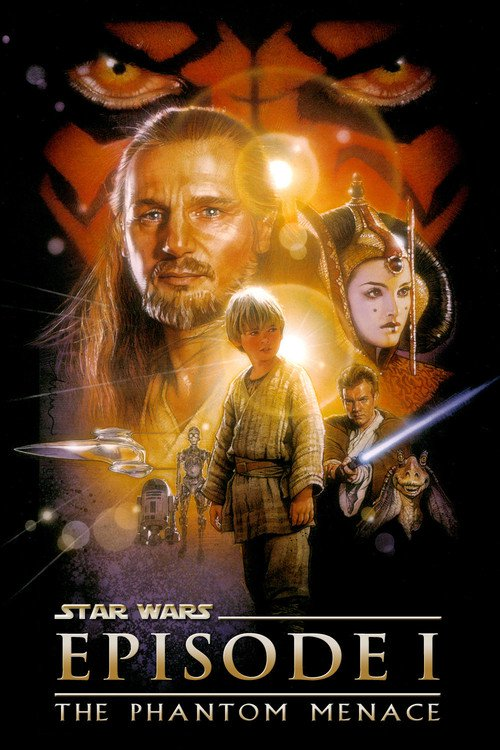

,0.983,,0.973,,0.965,,0.961,,0.960


In [41]:
display_similar(2628, num=5, q="title:(NOT trek)")

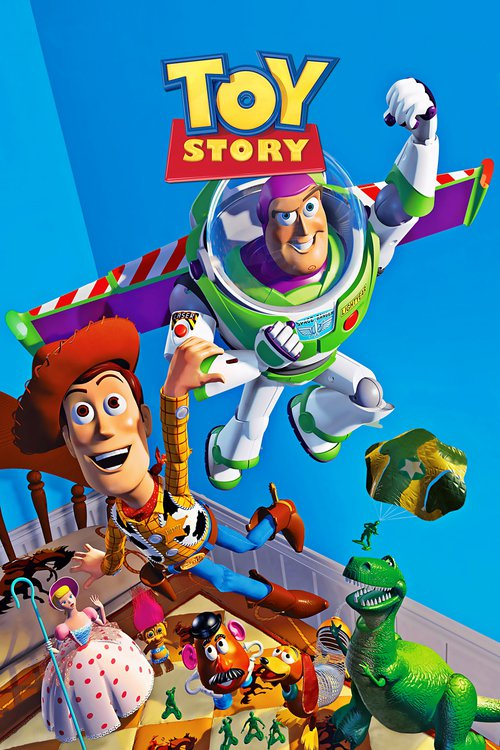

,0.989,,0.977,,0.973,,0.972,,0.970


In [51]:
display_similar(1, num=5, q="genres:children")